In [46]:
from tempfile import tempdir
import SimpleITK as sitk
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
import sys
#import seaborn as sns
import pandas as pd

In [51]:
patID = "1088"
patID_l = "0001088"

url_20f = 'D:/data/prostateMR_radiomics/nifti/20fractions/'
url_20f_new = 'D:/data/prostateMR_radiomics/nifti/20fractions_new/'
url_SABR = 'D:/data/prostateMR_radiomics/nifti/SABR/'
url_SABR_new = 'D:/data/prostateMR_radiomics/nifti/SABR_new/'

url = url_SABR + patID_l 
scanDir = os.listdir(url)

scan_info = pd.read_csv('D:/data/Aaron/ProstateMRL/Data/MRLPacks/ScanInfo/' + patID + '.csv')
scan_info = scan_info.dropna()

output = 'D:/data/Aaron/ProstateMRL/Data/Extraction/MRLPacks/MeanValues/' 

print("Patient Directory: " + url)
print("Output Directory: " + output)

#print(scan_info.head())


Patient Directory: D:/data/prostateMR_radiomics/nifti/SABR/0001088
Output Directory: D:/data/Aaron/ProstateMRL/Data/Extraction/MRLPacks/MeanValues/


In [52]:
def MaskedImage(image_array, mask_url):
    image = sitk.ReadImage(image_url)
    image_array = sitk.GetArrayFromImage(image)
    
    mask = sitk.ReadImage(mask_url)
    mask_array = sitk.GetArrayFromImage(mask) 
    if "glute" in mask_url:
        mask_array = mask_array / 13
    
    if image_array.shape != mask_array.shape:
       # print(image_url, mask_url)
       # print(image_array.shape, mask_array.shape)
        mean = np.nan
        std = np.nan
    
    else:
        masked_image = ma.masked_array(image_array, mask=np.logical_not(mask_array), keep_mask=True, hard_mask=True)
        mean = np.mean(masked_image.flatten())
        std = np.std(masked_image.flatten())

    return mean, std    
    



In [53]:
results_df = pd.DataFrame(columns=["PatID", "MRCont", "Fraction","ScanDate", "ScanTime", "Scan", "Observer", "Region", "Mean"])
scanValues = {"PatID":[], "MRCont":[], "Fraction":[], "ScanDate":[], "ScanTime":[], "Scan":[], "Observer": [], "Region": [], "Mean":[]}

In [56]:
fractions = scan_info.Fraction.unique()
MRs = scan_info.MRContour.unique()
#print(fractions)
for i in fractions:
    #print(i)
    MR = MRs[i].replace(' ', '')
    fraction = fractions[i]

    temp_df = scan_info.loc[scan_info['Fraction'] == fractions[i]]
    #temp_df = scan_info.loc[scan_info['Fraction'] == fractions[i]]
    print('Pat: ' + patID + ' Fraction: ' + str(fraction) + ' MR: ' + MR)

    scanValues["PatID"] = patID
    scanValues["MRCont"] = MR
    scanValues["Fraction"] = fraction
    
    scanValues["ScanDate"] = temp_df.ContourDate.unique()[0]
    scantimes = temp_df.ScanTime.unique()

    scanValues["Observer"] = "RP"
    scanValues["Region"] = "Prostate" # change when add in more

    
    numberofscans = 0
    for j in os.scandir(url + '/' + MR):
        #print(j.name)
        file = j.name
        glute_url = url + '/' + MR + '/' + patID_l + '_' + MR + '_glute.nii'
        pros_url = url + '/' + MR + '/' + patID_l + '_' + MR + '_shrunk_pros.nii'
        
        if "reg" in file:
            numberofscans = numberofscans + 1
            scan = file.split("_")
            scan = scan[4]
            scan = int(scan[0:1])
            scanValues["Scan"] = scan

            scanValues["ScanTime"] = scantimes[numberofscans - 1]

            image_url = url + '/' + MR + '/' + file
            #glute_image = MaskedImage(image_url,glute_url)[1]
            pros_image = MaskedImage(image_url, pros_url)[1]
            scanValues["Mean"] = pros_image
            print(file)
            #print(" Pros: " + str(pros_image))
            results_df = results_df.append(scanValues, ignore_index=True)

                 


Pat: 1088 Fraction: 0 MR: MR6
0001088_MR6_reg_img_1.nii
0001088_MR6_reg_img_2.nii
0001088_MR6_reg_img_3.nii
0001088_MR6_reg_img_6.nii
Pat: 1088 Fraction: 1 MR: MR10
0001088_MR10_reg_img_1.nii
0001088_MR10_reg_img_2.nii
0001088_MR10_reg_img_3.nii
0001088_MR10_reg_img_4.nii
Pat: 1088 Fraction: 2 MR: MR13
0001088_MR13_reg_img_1.nii
0001088_MR13_reg_img_2.nii
0001088_MR13_reg_img_3.nii
0001088_MR13_reg_img_4.nii
Pat: 1088 Fraction: 3 MR: MR19
0001088_MR19_reg_img_1.nii
0001088_MR19_reg_img_2.nii
0001088_MR19_reg_img_3.nii
0001088_MR19_reg_img_4.nii
0001088_MR19_reg_img_5.nii
0001088_MR19_reg_img_6.nii
Pat: 1088 Fraction: 4 MR: MR25
0001088_MR25_reg_img_1.nii
0001088_MR25_reg_img_2.nii
0001088_MR25_reg_img_3.nii
0001088_MR25_reg_img_4.nii
0001088_MR25_reg_img_5.nii
0001088_MR25_reg_img_6.nii


In [ ]:
firstmean = results_df.iloc[0]['Mean']
results_df["SignalDiff"] = firstmean - results_df['Mean']

<AxesSubplot:xlabel='Fraction', ylabel='SignalDiff'>

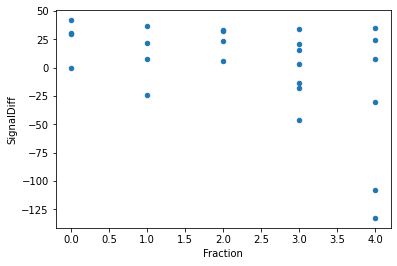

In [ ]:
results_df.plot(x='Fraction', y='SignalDiff', kind='scatter')